# Podcast Recommender
In providing tools for podcasters, I thought it might be important to have some metric of a podcast's similarity to another.

This could be useful for providing recommendations for listeners, or automatic grouping of podcasts by genre, or providing tailored assistance to podcast creators (for example, there might be some advice that works really well for non-fiction nature podcasts, but not so well for fictional comedy podcasts).

Obviously to accomplish this task well, you would want to use all sorts of data, like the tags which the podcast maker gave to their podcast, the text of the podcast description, the number of episodes, the length of each episode and so on.

## The Challenge
However, sometimes this data is missing or misleading, such as if a podcaster gives the wrong tags, or no tags at all.

It also might not capture deeper similarities between podcasts. For example, if we only have one 'Comedy' tag, we might end up lumping very different podcasts into the same category; imagine a cynical, nihilistic, dark comedy vs a uplifting, optimistic, family-friendly comedy. Adding more tags is only a stop-gap solution, as there is always more nuance, and with every new tag, you increase the likelihood that a person will not be aware of exactly which tag to apply to their podcast.

## My Approach
Embeddings seem like a good solution to this problem. They provide a way to represent each podcast, such that we can measure how similar each one is to the others, and cluster similar podcasts together.

One way of generating these could be through "mutual likes". Given the fact that people tend to have reasonably stable preferences, if a person likes two podcasts, it is more likely than not that those two podcasts share something in common. Obviously this is a noisy assumption, since some people get different things from different podcasts, but this is the sort of data that I thought would be likely for a podcasting company to have.

In [86]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)

import numpy as np

from sklearn.preprocessing import normalize

from keras.layers import Input, Embedding, Dot, Reshape, Dense, Flatten
from keras.models import Model, Sequential

from itertools import combinations, product, permutations

import random

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt



np.random.seed(42)

## Simulating the data
Since I didn't have access to any actual data, I decided to simulate it.

The approach is as follows: each podcast has a set of attributes. Positive values mean that they have a lot of the attribute, negative values mean that they have a lot of the opposite attribute, and values close to zero mean that they are somewhere in between.

Each of the people has a unique set of preferences for these attributes. These are then multiplied together and summed, to give a rating of how much a person liked that podcast. Positive values mean that they liked it a lot, negative values mean that they disliked it a lot. 

For example, if a very calm podcast had an attribute of "-5 Scary", and the person had a preference for "-5 Scary", that would become a very positive value. Likewise if the podcast had two positive values, that becomes a very positive rating. If there is a mismatch, they become negative.

Later on, I threshold this data, to simulate people giving either a "thumbs up" or a "thumbs down".

In [87]:
num_people = 1000

# pod_attributes = ["story-like","scary","informative","brief","sci-fi-like","dramatic",
#                   "optimistic","comedic","gossipy","kid-friendly"]
# pods = ["Folk Stories of America", "Folk Stories of England", "Life gives me Lemons", 
#         "My First Show", "Spooky Stories", "Two Thumbs Up",  "Weird Cats", "Friendly Inc."]

num_attributes = 15
pod_attributes = [x for x in range(num_attributes)]

num_pods = 200
pods = [x for x in range(num_pods)]

num_pods = len(pods)
pod_ids = [x for x in range(num_pods)]


shape = (num_people,len(pod_attributes))
means = [0 for x in pod_attributes]
cov_max = [3 for x in pod_attributes]
covs = np.diag(cov_max)

# Each podcast has a different set of attributes and each person 
# has a different set of preferences for those attributes.
prefs = np.random.multivariate_normal(means, covs, num_people)
pod_attrs = np.random.multivariate_normal(means, covs, num_pods)

final = np.zeros((num_people, num_pods))
i = 0
for person in prefs:
    each = person * pod_attrs
    final[i] = each.sum(axis=1)
    i+=1


In [88]:
# Normalisation
normed = np.array(normalize(final, norm="l2"))

threshold = 0.17
liked = (normed > threshold).astype(int)
disliked = (normed < -threshold).astype(int)




# This is discarding those people who only liked or disliked one podcast:
multiprefs_liked = liked.sum(axis=1) > 1
multiprefs_disliked = disliked.sum(axis=1) > 1


print("Number of people with 2 or more liked podcasts:", np.sum(multiprefs_liked))
print("Number of people with 2 or more disliked podcasts:", np.sum(multiprefs_disliked))


Number of people with 2 or more liked podcasts: 504
Number of people with 2 or more disliked podcasts: 471


In [89]:
def get_dissimilar_pair(both):
    # Choose a random person.
    chosen_person = random.choices(both)[0]
    
    resample = True
    attempts = 0
    while resample:
    # Choose a random podcast
        first_pod_ix, second_pod_ix = random.sample(range(num_pods), 2)

        first_pod_polarity = chosen_person[first_pod_ix]
        second_pod_polarity = chosen_person[first_pod_ix]

        if first_pod_polarity == 0 or second_pod_polarity == 0 or first_pod_polarity == -second_pod_polarity:
            resample = False
        elif attempts > 1000:
            print("This person either liked everything, or disliked everything.")
            resample = False
    
    return (first_pod_ix, second_pod_ix)


disliked[disliked > 0] = -1

both = liked + disliked

contains_similar = multiprefs_liked + multiprefs_disliked

potential_similar_pairs = []

for person in both[multiprefs_liked]:
    person_liked = np.where(person == 1)[0]
    potential_similar_pairs += list(permutations(person_liked, 2))
    
for person in both[multiprefs_disliked]:
    person_disliked = np.where(person == -1)[0]
    potential_similar_pairs += list(permutations(person_disliked, 2))
    
unique_similar_pairs = set(potential_similar_pairs)

potential_dissimilar_pairs = []
for i in range(len(potential_similar_pairs)):
    dissimilar_pair = get_dissimilar_pair(both)
    potential_dissimilar_pairs.append(dissimilar_pair)
    

In [90]:
random.shuffle(potential_dissimilar_pairs)
random.shuffle(potential_similar_pairs)
    
similar = potential_similar_pairs
dissimilar = potential_dissimilar_pairs

similar_labels = [1 for x in similar]
dissimilar_labels = [0 for x in dissimilar]

Xs = np.array(similar + dissimilar)
labels = np.array(similar_labels + dissimilar_labels)


train_size = int(len(Xs) * 0.75)

shuffled = list(zip(Xs, labels))
random.shuffle(shuffled)

train = shuffled[0:train_size]
test = shuffled[train_size:]
# train Xs and train ys, also need to create a set of all of the ones that weren't selected
train_Xs = np.array([x[0] for x in train])
train_ys = np.array([x[1] for x in train])

test_Xs = np.array([x[0] for x in test])
test_ys = np.array([x[1] for x in test])

print("Training set:\t{}".format(len(train)))
print("Testing set:\t{}".format(len(test)))

Training set:	6297
Testing set:	2099


In [91]:
embedding_size = 50

model = Sequential()
model.add(Embedding(input_dim = num_pods, output_dim = embedding_size, input_length=2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2, 50)             10000     
_________________________________________________________________
flatten_2 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 10,101
Trainable params: 10,101
Non-trainable params: 0
_________________________________________________________________
None


In [92]:
# Fitting the model
model.fit(train_Xs, train_ys, epochs=25, verbose=1)

# Evaluation
loss, accuracy = model.evaluate(test_Xs, test_ys, verbose=1)

Epoch 1/25
6297/6297 [==============================] - 1s 113us/step - loss: 0.6071 - acc: 0.7489
Epoch 2/25
6297/6297 [==============================] - 0s 55us/step - loss: 0.4335 - acc: 0.8174
Epoch 3/25
6297/6297 [==============================] - 0s 56us/step - loss: 0.3949 - acc: 0.8245
Epoch 4/25
6297/6297 [==============================] - 0s 55us/step - loss: 0.3854 - acc: 0.8282
Epoch 5/25
6297/6297 [==============================] - 0s 58us/step - loss: 0.3809 - acc: 0.8266
Epoch 6/25
6297/6297 [==============================] - 0s 57us/step - loss: 0.3787 - acc: 0.8263
Epoch 7/25
6297/6297 [==============================] - 0s 54us/step - loss: 0.3769 - acc: 0.8293
Epoch 8/25
6297/6297 [==============================] - 0s 55us/step - loss: 0.3754 - acc: 0.8275
Epoch 9/25
6297/6297 [==============================] - 0s 56us/step - loss: 0.3748 - acc: 0.8258
Epoch 10/25
6297/6297 [==============================] - 0s 54us/step - loss: 0.3745 - acc: 0.8280
Epoch 11/25
6297/6

In [93]:
print('Accuracy: {}'.format(accuracy*100))

Accuracy: 80.562172468757


In [94]:
embeddings = model.layers[0].get_weights()[0]

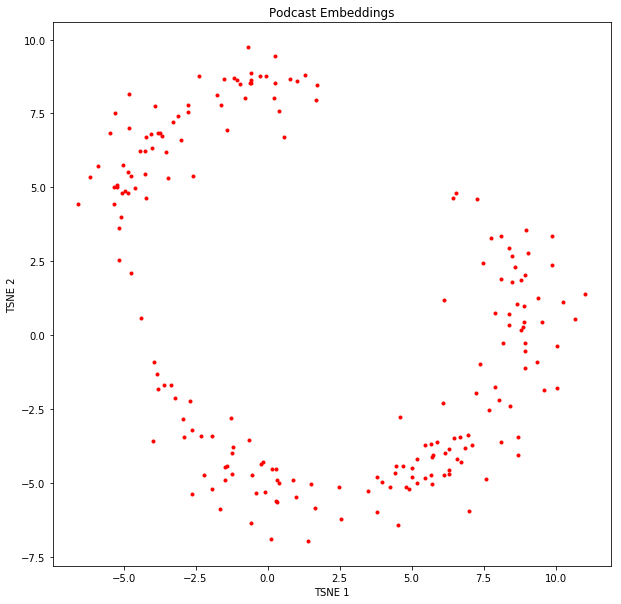

In [95]:
components = 2
reduced_pods = TSNE(components, metric = 'cosine').fit_transform(embeddings)

plt.figure(figsize = (10, 10))
plt.plot(reduced_pods[:, 0], reduced_pods[:, 1], 'r.')
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Podcast Embeddings');